<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/bed_occupancy_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
import random
# set the numpy only output 3-digit after decimal point
np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)


2.8.0


In [ ]:
!wget https://storage.googleapis.com/pet-detect-239118/bed_occupancy/bed_occupancy_1.csv ./bed_occupancy_1.csv

--2022-05-20 07:19:04--  https://storage.googleapis.com/pet-detect-239118/bed_occupancy/bed_occupancy_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40454 (40K) [text/csv]
Saving to: ‘bed_occupancy_1.csv’

bed_occupancy_1.csv 100%[===================>]  39.51K  --.-KB/s    in 0s      

2022-05-20 07:19:04 (105 MB/s) - ‘bed_occupancy_1.csv’ saved [40454/40454]

--2022-05-20 07:19:04--  http://./bed_occupancy_1.csv
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-20 07:19:04--
Total wall clock time: 0.2s
Downloaded: 1 files, 40K in 0s (105 MB/s)


In [ ]:
dataset = pd.read_csv('/content/bed_occupancy_1.csv')
dataset = dataset.dropna()
print(dataset.isna().sum())
print(dataset.shape)

Date                       0
Facility                   0
Location Mnemonic          0
TotFundedBeds              0
TotDischarges              0
TotInpatientCensusDays     0
TotInpatientServiceDays    0
ICDOccupancyDaily          0
dtype: int64
(1095, 8)


In [ ]:
dataset.columns

Index(['Date', 'Facility', 'Location Mnemonic', 'TotFundedBeds',
       'TotDischarges', 'TotInpatientCensusDays', 'TotInpatientServiceDays',
       'ICDOccupancyDaily'],
      dtype='object')

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.sort_values(by=['Date'], inplace=True)

In [ ]:
dataset = dataset.set_index('Date')

In [ ]:
print(dataset.shape)

(1095, 7)


In [ ]:
dataset.head()

,Facility,Location Mnemonic,TotFundedBeds,TotDischarges,TotInpatientCensusDays,TotInpatientServiceDays,ICDOccupancyDaily
Date,,,,,,,
2017-01-01,SJRH,4AN,31,0,31,31,1.0
2017-01-02,SJRH,4AN,31,0,31,31,1.0
2017-01-03,SJRH,4AN,31,0,31,31,1.0
2017-01-04,SJRH,4AN,31,1,31,31,1.0
2017-01-05,SJRH,4AN,31,0,31,31,1.0


In [ ]:
dataset.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=1095, freq=None)

In [ ]:
bed_series = pd.Series(dataset['ICDOccupancyDaily'].values,
                     index = pd.date_range('2017-01-01' ,
                                           periods = 1095,
                                           freq = 'D'))
bed_series.index = np.arange(1, len(bed_series)+1)

In [ ]:
bed_df = dataset[['ICDOccupancyDaily']]
bed_df['diff1'] = bed_df['ICDOccupancyDaily'].diff()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


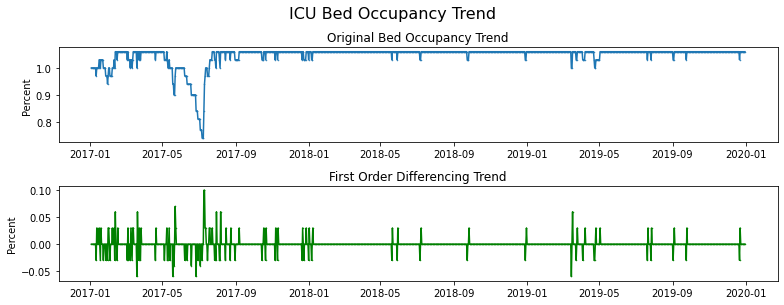

In [ ]:
fig, ax = plt.subplots(figsize=(11, 4))
fig.subplots_adjust(top=0.8)

ax = plt.subplot(2,1,1)
ax.set_title("Original Bed Occupancy Trend")
ax.plot(bed_df.iloc[2:, 0],
marker='.', markersize=1, linestyle='-', label='First Order Differencing')
ax.set_ylabel('Percent')

ax = plt.subplot(2,1,2)
ax.set_title("First Order Differencing Trend")
ax.plot(bed_df.iloc[2:, 1],
marker='.', markersize=1, linestyle='-', color='g', label='First Order Differencing')
ax.set_ylabel('Percent')

fig.suptitle("ICU Bed Occupancy Trend", y=1.05, size=16)
fig.tight_layout()

In [ ]:
# Test for stationarity
def stationarity_test(timeseries):
    """"Augmented Dickey-Fuller test
    A test for stationarity"""
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag = "AIC")
    df_output = pd.Series(df_test[0:4],
                          index = ["Test statistic", "p-value",
                                   "Number of lags used",
                                   "Number of observations used"])
    print(df_output)

In [ ]:
stationarity_test(bed_df['ICDOccupancyDaily'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Results of Dickey-Fuller Test:
Test statistic                   -3.977323
p-value                           0.001534
Number of lags used              15.000000
Number of observations used    1079.000000
dtype: float64


In [ ]:
# Importing ACF and PACF plot functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

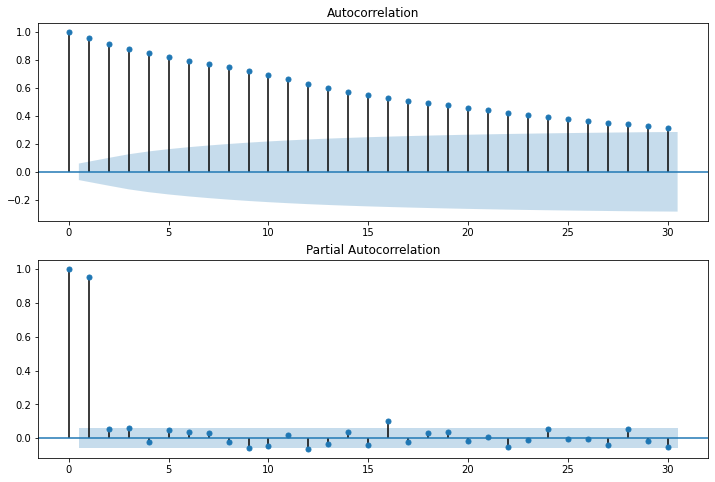

In [ ]:
# Autocorrelation and partial autocorrelation
# autocorrelation describes the correlation between the values of an ordered series at different time points
# Two plots on one sheet
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12,8))
plot_acf(bed_series, lags= 30, ax = ax1)
plot_pacf(bed_series, lags = 30, ax = ax2);

In [ ]:
# Simple moving average (rolling mean)
# Note: the rolling methods are applicable only on pandas Series
#                                            and DataFrame objects
def plot_rolling(timeseries, window):
    rol_mean = timeseries.rolling(window).mean()
    rol_std = timeseries.rolling(window).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rol_std, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation (window = "+str(window)+")")
    plt.show()

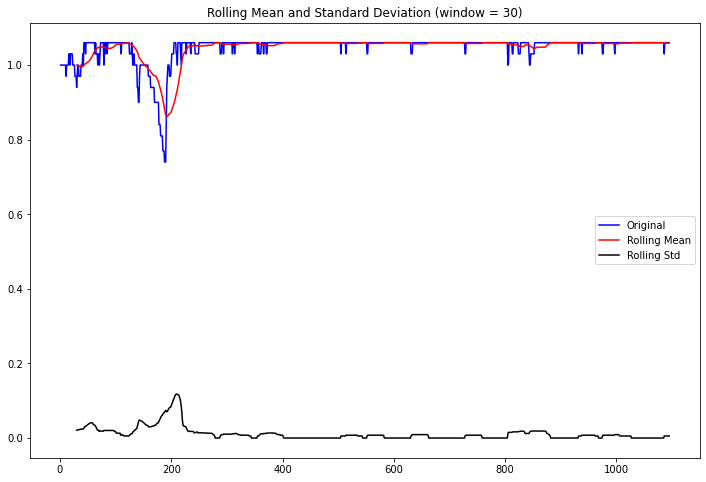

In [ ]:
plot_rolling(bed_series, 30)

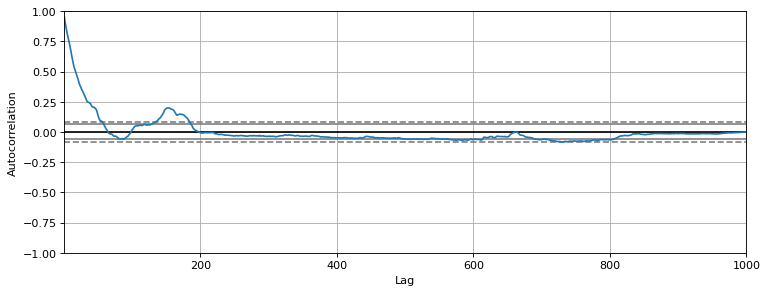

In [ ]:
plt.figure(figsize=(11,4), dpi= 80)
pd.plotting.autocorrelation_plot(bed_df.iloc[0:1000, 0])

In [ ]:
date_time = pd.to_datetime(dataset.index, format='%Y-%m-%d')
df = dataset[['TotDischarges', 'TotInpatientCensusDays','TotInpatientServiceDays', 'ICDOccupancyDaily']]

In [ ]:
timestamp_s = date_time.map(datetime.timestamp)
day = 24*60*60
week = 7*day
month = 4*week
year = (365.2425)*day

In [ ]:
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
df['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))
df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.80)]
val_df = df[int(n*0.80):int(n*0.90)]
test_df = df[int(n*0.90):]
num_features = df.shape[1]

In [ ]:
train_mean = df.mean()
train_std = df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Text(0.5, 1.0, 'Time of per Month signal')

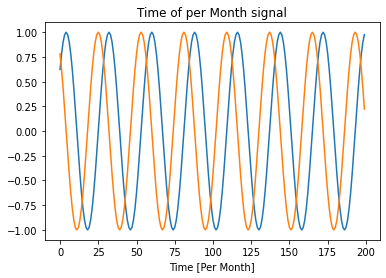

In [ ]:
plt.plot(np.array(df['Month sin'][:200]))
plt.plot(np.array(df['Month cos'][:200]))
plt.xlabel('Time [Per Month]')
plt.title('Time of per Month signal')

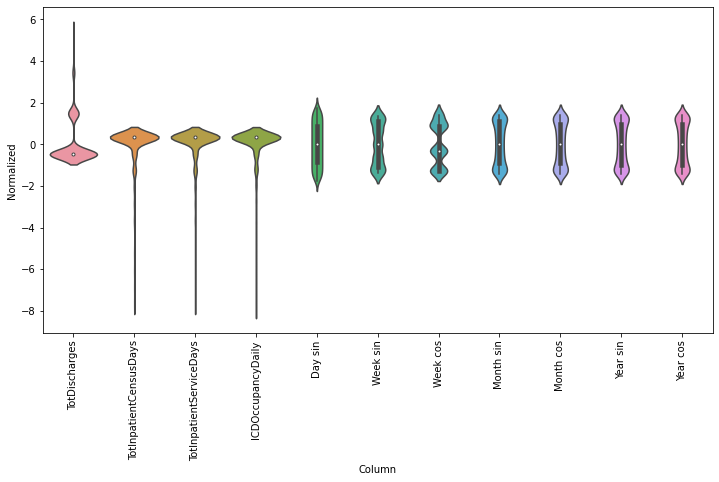

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col='ICDOccupancyDaily', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
train_df.columns

Index(['TotDischarges', 'TotInpatientCensusDays', 'TotInpatientServiceDays',
       'ICDOccupancyDaily', 'Day sin', 'Week sin', 'Week cos', 'Month sin',
       'Month cos', 'Year sin', 'Year cos'],
      dtype='object')

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1, label_columns=['ICDOccupancyDaily'])

In [ ]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['ICDOccupancyDaily']

In [ ]:
wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1, label_columns=['ICDOccupancyDaily'])

In [ ]:
wide_window

Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [1 2 3 4 5 6 7]
Label column name(s): ['ICDOccupancyDaily']

Define the baseline model - use the next step value as the predicted value

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

In [ ]:
val_performance = {}
performance = {}
print("Evaluating Baseline model ...")
val_performance['Baseline'] = baseline.evaluate(wide_window.val, verbose=2)
print("Testing Baseline model ...")
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=2)

Evaluating Baseline model ...
1/1 - 2s - loss: 0.8955 - mean_absolute_error: 0.7211 - mean_squared_error: 0.8955 - root_mean_squared_error: 0.9463 - mean_absolute_percentage_error: 213.2074 - 2s/epoch - 2s/step
Testing Baseline model ...
1/1 - 0s - loss: 0.8523 - mean_absolute_error: 0.6945 - mean_squared_error: 0.8523 - root_mean_squared_error: 0.9232 - mean_absolute_percentage_error: 205.9973 - 172ms/epoch - 172ms/step


Define the train function

In [ ]:
MAX_EPOCHS = 200

In [ ]:
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=0.0004),
                metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history

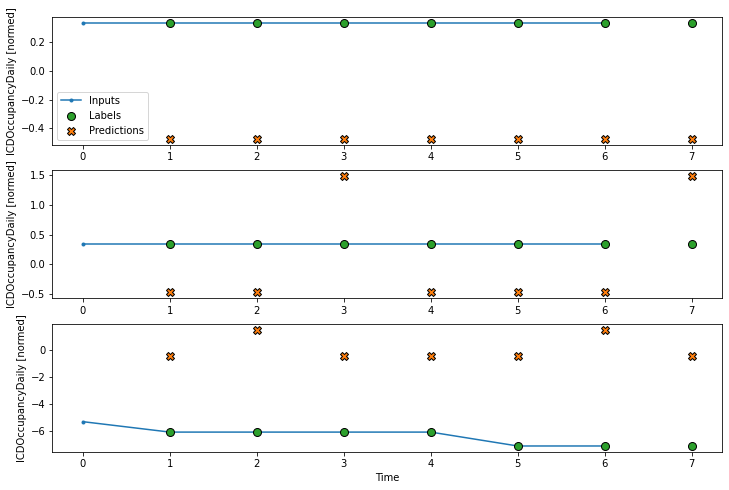

In [ ]:
wide_window.plot(baseline)

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (256, 7, 11)
Output shape: (256, 7, 11)


In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 51ms/step - loss: 0.0316 - mean_absolute_error: 0.1049 - mean_squared_error: 0.0316 - root_mean_squared_error: 0.1777 - mean_absolute_percentage_error: 29.7410


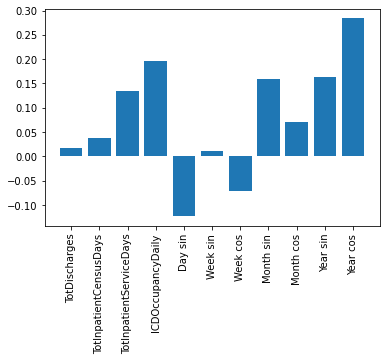

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

Multi_step model

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
CONV_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['ICDOccupancyDaily'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['ICDOccupancyDaily']

In [ ]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['ICDOccupancyDaily'])

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): ['ICDOccupancyDaily']

Convolution neural network

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [ ]:
history = compile_and_fit(conv_model, wide_conv_window)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 50ms/step - loss: 0.0268 - mean_absolute_error: 0.1078 - mean_squared_error: 0.0268 - root_mean_squared_error: 0.1639 - mean_absolute_percentage_error: 30.5556


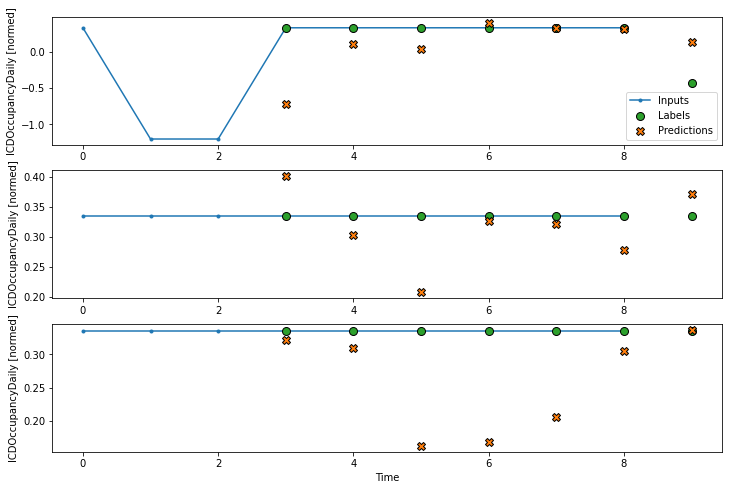

In [ ]:
wide_conv_window.plot(conv_model)

Recurrent Neural Network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 54ms/step - loss: 0.0278 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0278 - root_mean_squared_error: 0.1667 - mean_absolute_percentage_error: 28.9945


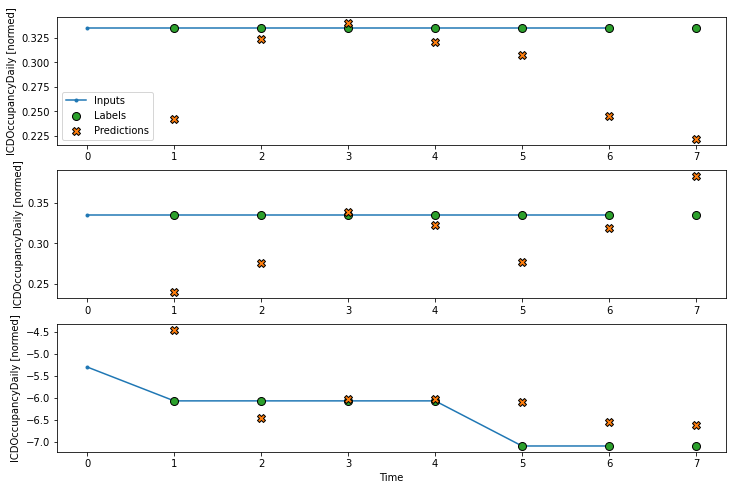

In [ ]:
wide_window.plot(lstm_model)

Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
OUT_STEPS = 1

feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [ ]:
history = compile_and_fit(feedback_model, wide_window)

val_performance['AR LSTM'] = feedback_model.evaluate(wide_window.val)
performance['AR LSTM'] = feedback_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 53ms/step - loss: 0.0197 - mean_absolute_error: 0.0633 - mean_squared_error: 0.0197 - root_mean_squared_error: 0.1403 - mean_absolute_percentage_error: 17.1724


Comparison of all single-output networks

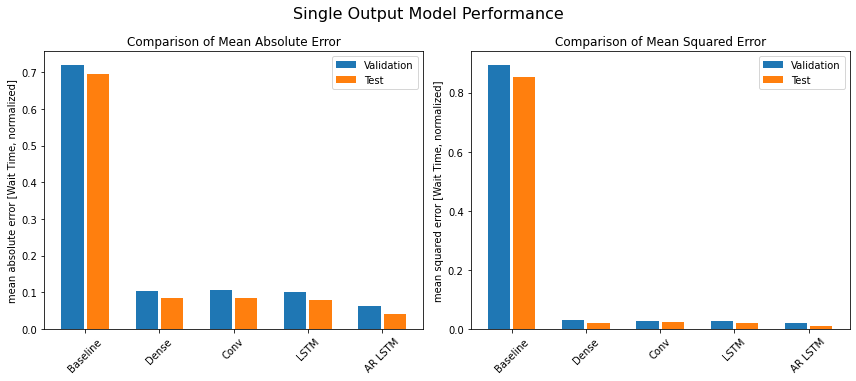

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]


metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in val_performance.values()]
test_mape = [v[metric_index] for v in performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

fig.suptitle("Single Output Model Performance", y=1.05, size=16)
fig.tight_layout()

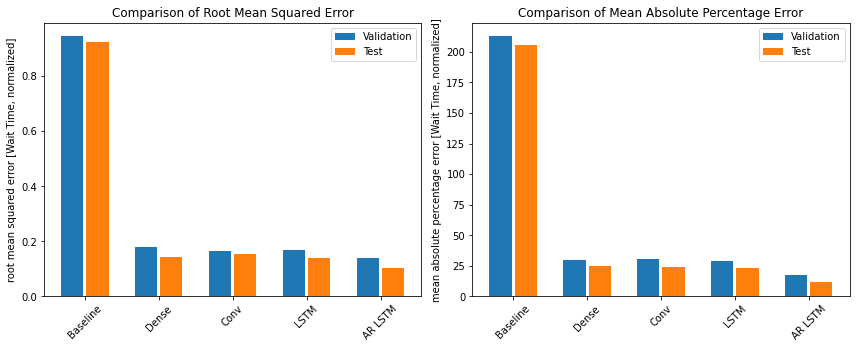

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Baseline    : 0.6945
Dense       : 0.0860
Conv        : 0.0843
LSTM        : 0.0805
AR LSTM     : 0.0416
------ MSE Comparison ------
Baseline    : 0.8523
Dense       : 0.0207
Conv        : 0.0238
LSTM        : 0.0192
AR LSTM     : 0.0108
------ RMSE Comparison ------
Baseline    : 0.9232
Dense       : 0.1440
Conv        : 0.1544
LSTM        : 0.1384
AR LSTM     : 0.1038
------ MAPE Comparison ------
Baseline    : 205.9973
Dense       : 24.7750
Conv        : 24.0256
LSTM        : 23.0219
AR LSTM     : 11.5251


Multi-output models

In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=7, label_width=7, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (256, 7, 11)
Labels shape (batch, time, features): (256, 7, 11)


In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val, verbose=0)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

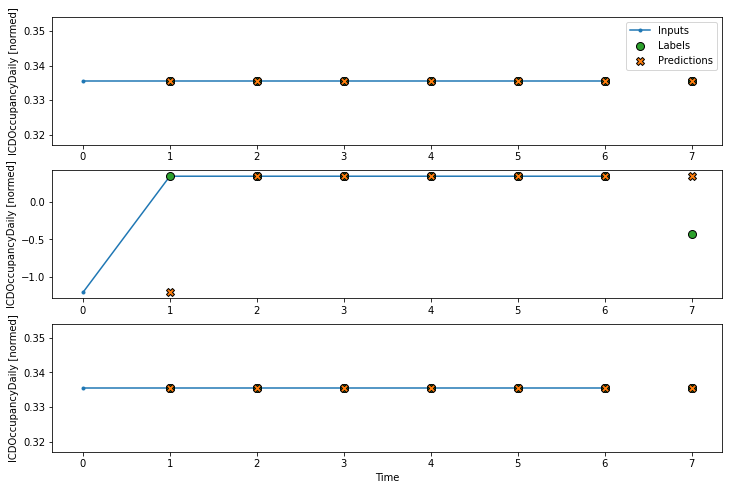

In [ ]:
wide_window.plot(baseline)

Dense model

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1/1 [==============================] - 0s 52ms/step - loss: 0.1371 - mean_absolute_error: 0.1885 - mean_squared_error: 0.1371 - root_mean_squared_error: 0.3703 - mean_absolute_percentage_error: 167.8401


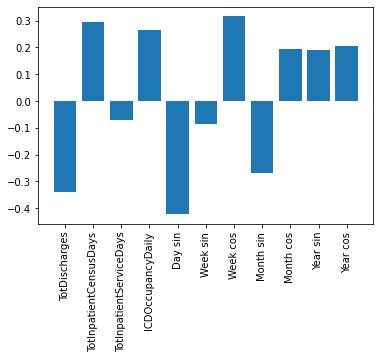

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=dense.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

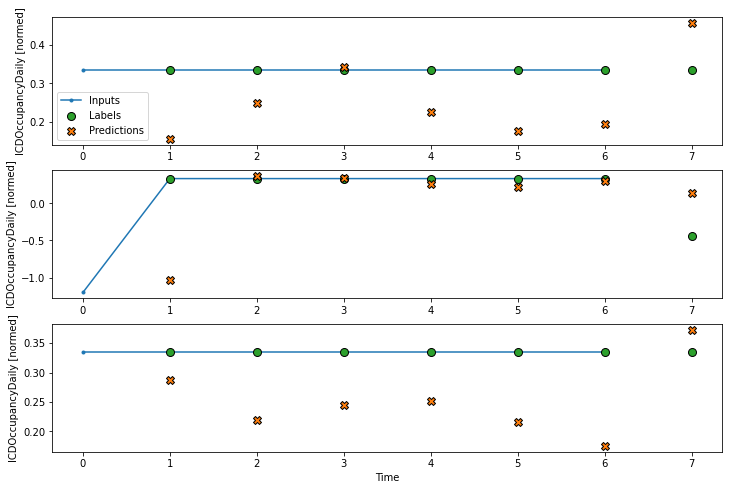

In [ ]:
wide_window.plot(dense)

Convolutional network

In [ ]:
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1)

wide_conv_window

Total window size: 10
Input indices: [0 1 2 3 4 5 6 7 8]
Label indices: [3 4 5 6 7 8 9]
Label column name(s): None

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
])

In [ ]:
history = compile_and_fit(conv_model, wide_conv_window)

val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

1/1 [==============================] - 0s 49ms/step - loss: 0.1517 - mean_absolute_error: 0.2097 - mean_squared_error: 0.1517 - root_mean_squared_error: 0.3895 - mean_absolute_percentage_error: 202.6839


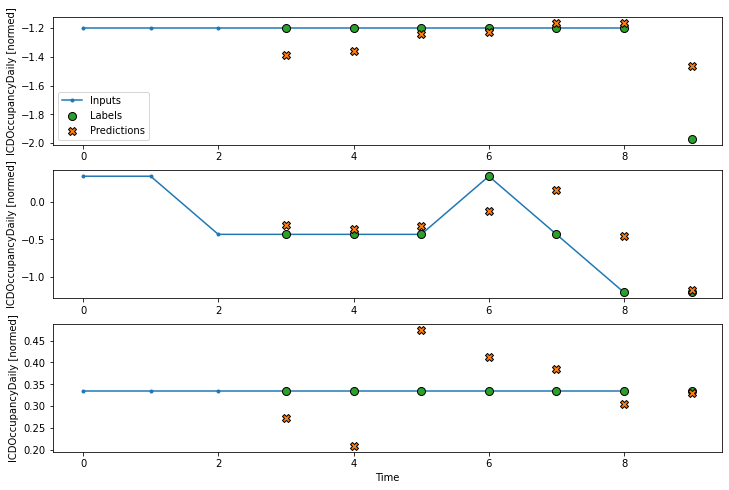

In [ ]:
wide_conv_window.plot(conv_model)

LSTM network

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

1/1 [==============================] - 0s 83ms/step - loss: 0.1751 - mean_absolute_error: 0.2298 - mean_squared_error: 0.1751 - root_mean_squared_error: 0.4185 - mean_absolute_percentage_error: 137.2744


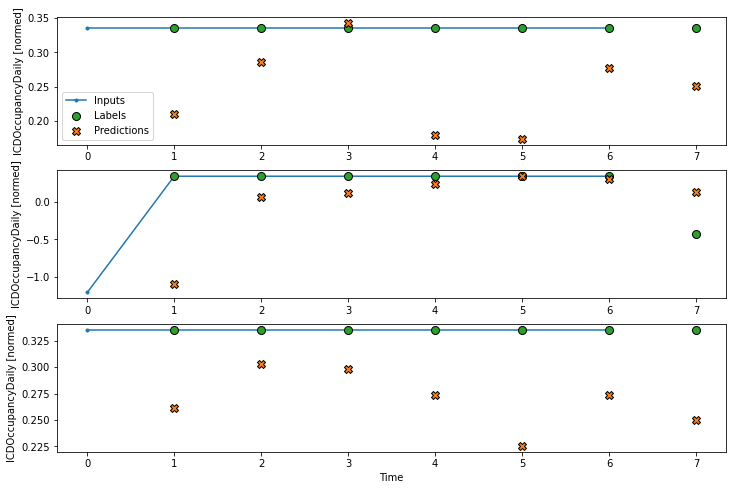

In [ ]:
wide_window.plot(lstm_model)

LSTM with Residual connections

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 52ms/step - loss: 0.1495 - mean_absolute_error: 0.1766 - mean_squared_error: 0.1495 - root_mean_squared_error: 0.3866 - mean_absolute_percentage_error: 236.3427


Autoregressive model

In [ ]:
OUT_STEPS = 1

feedback_model = FeedBack(units=64, out_steps=OUT_STEPS)
history = compile_and_fit(feedback_model, wide_window)

val_performance['AR LSTM'] = feedback_model.evaluate(wide_window.val)
performance['AR LSTM'] = feedback_model.evaluate(wide_window.test, verbose=0)

1/1 [==============================] - 0s 48ms/step - loss: 0.3808 - mean_absolute_error: 0.3858 - mean_squared_error: 0.3808 - root_mean_squared_error: 0.6171 - mean_absolute_percentage_error: 303.9641


Comparison of multiple output models

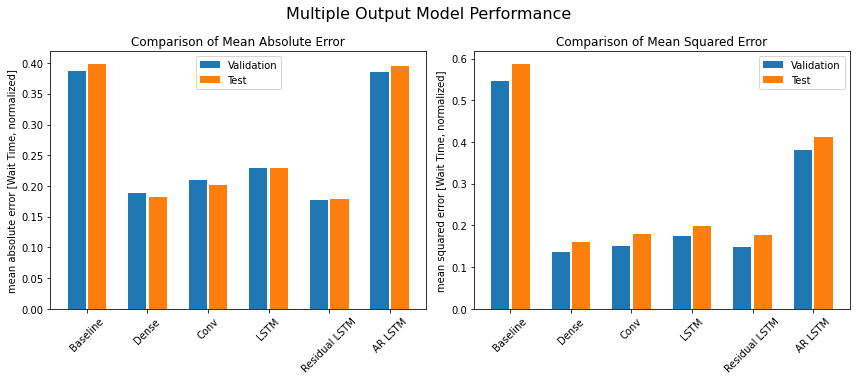

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]


metric_name = 'root_mean_squared_error'
metric_index = lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in val_performance.values()]
test_rmse = [v[metric_index] for v in performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in val_performance.values()]
test_mape = [v[metric_index] for v in performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

fig.suptitle("Multiple Output Model Performance", y=1.05, size=16)
fig.tight_layout()

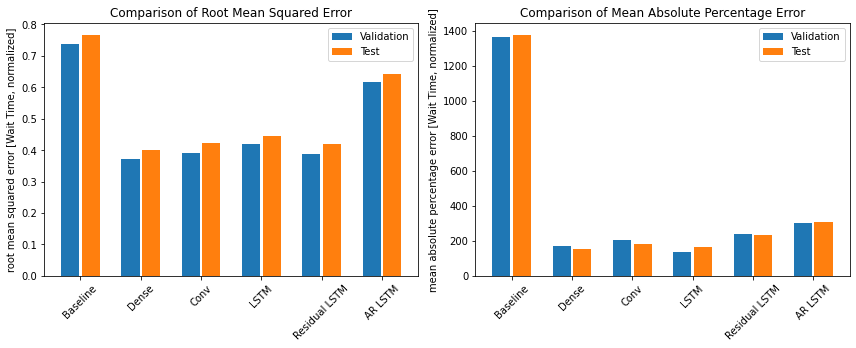

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Baseline    : 0.3992
Dense       : 0.1824
Conv        : 0.2018
LSTM        : 0.2293
Residual LSTM: 0.1793
AR LSTM     : 0.3949
------ MSE Comparison ------
Baseline    : 0.5879
Dense       : 0.1610
Conv        : 0.1797
LSTM        : 0.1993
Residual LSTM: 0.1771
AR LSTM     : 0.4111
------ RMSE Comparison ------
Baseline    : 0.7667
Dense       : 0.4013
Conv        : 0.4239
LSTM        : 0.4465
Residual LSTM: 0.4208
AR LSTM     : 0.6412
------ MAPE Comparison ------
Baseline    : 1375.6110
Dense       : 151.8065
Conv        : 180.7852
LSTM        : 165.0482
Residual LSTM: 232.9946
AR LSTM     : 308.9421


Multi-step models

Total window size: 14
Input indices: [0 1 2 3 4 5 6]
Label indices: [ 7  8  9 10 11 12 13]
Label column name(s): None

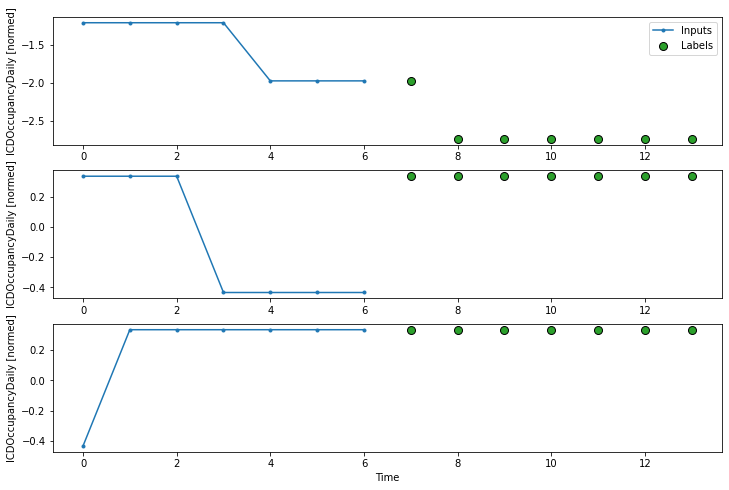

In [ ]:
OUT_STEPS = 7
multi_window = WindowGenerator(input_width=7,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Baseline model

1/1 [==============================] - 0s 178ms/step - loss: 0.8750 - mean_absolute_error: 0.5375 - mean_squared_error: 0.8750 - root_mean_squared_error: 0.9354 - mean_absolute_percentage_error: 1475.4974


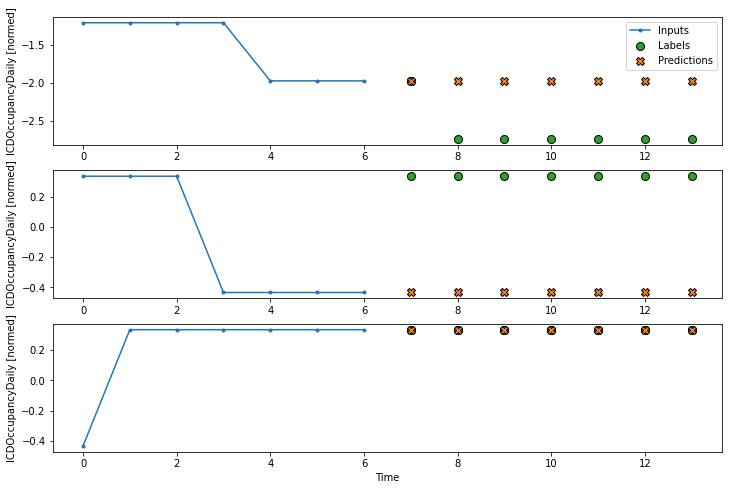

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1/1 [==============================] - 0s 170ms/step - loss: 0.5830 - mean_absolute_error: 0.3622 - mean_squared_error: 0.5830 - root_mean_squared_error: 0.7635 - mean_absolute_percentage_error: 749.2624


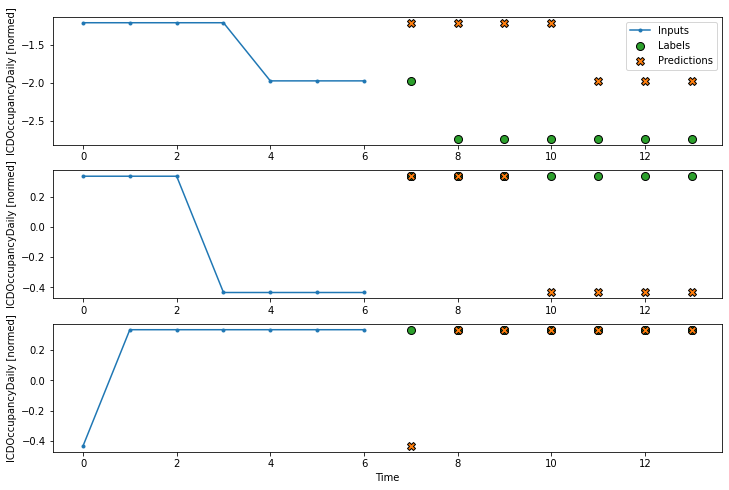

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Linear

1/1 [==============================] - 0s 50ms/step - loss: 0.4490 - mean_absolute_error: 0.5608 - mean_squared_error: 0.4490 - root_mean_squared_error: 0.6701 - mean_absolute_percentage_error: 256.2469


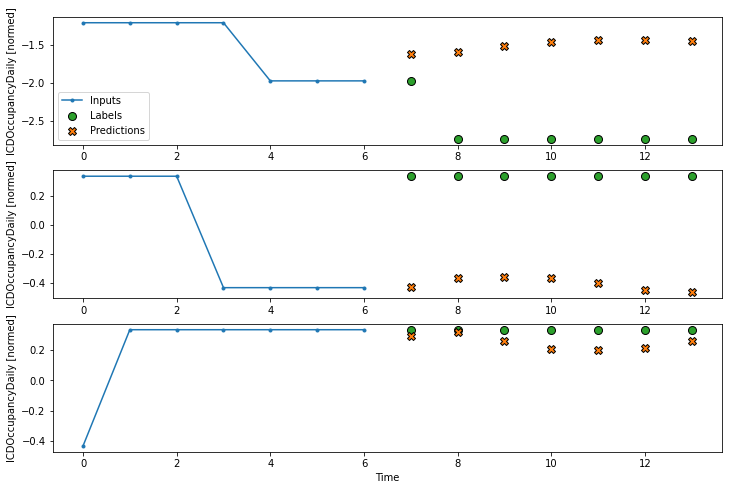

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

Dense

1/1 [==============================] - 0s 55ms/step - loss: 0.1660 - mean_absolute_error: 0.1851 - mean_squared_error: 0.1660 - root_mean_squared_error: 0.4074 - mean_absolute_percentage_error: 71.1641


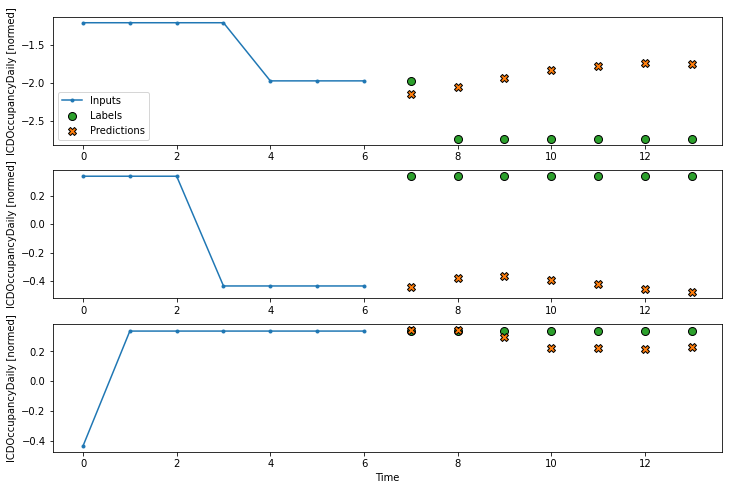

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(1024, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Convolutional neural network

1/1 [==============================] - 0s 48ms/step - loss: 0.1465 - mean_absolute_error: 0.1747 - mean_squared_error: 0.1465 - root_mean_squared_error: 0.3828 - mean_absolute_percentage_error: 88.1149


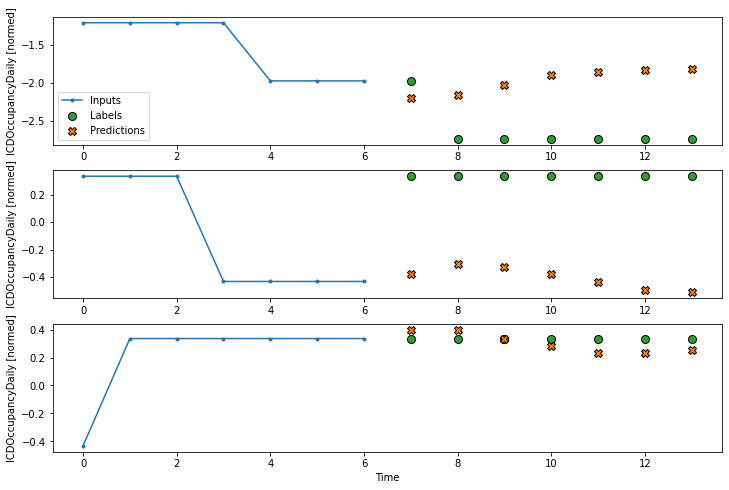

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

LSTM

1/1 [==============================] - 0s 51ms/step - loss: 0.1683 - mean_absolute_error: 0.1974 - mean_squared_error: 0.1683 - root_mean_squared_error: 0.4102 - mean_absolute_percentage_error: 104.3831


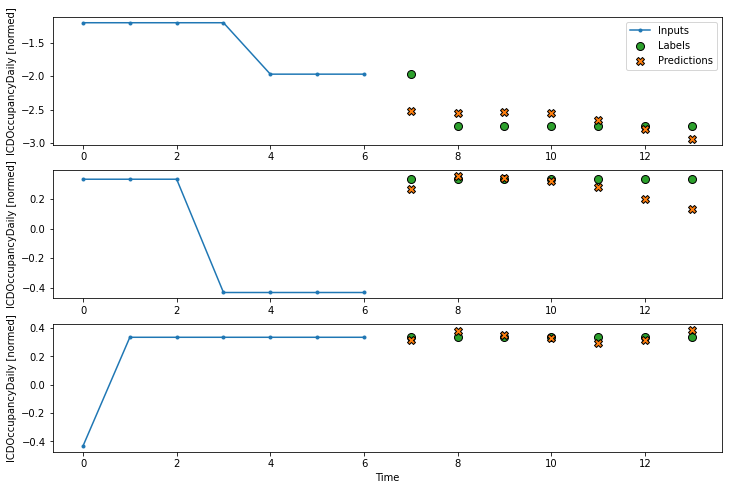

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Autoregressive model

In [ ]:
OUT_STEPS = 7

feedback_model = FeedBack(units=128, out_steps=OUT_STEPS)

1/1 [==============================] - 0s 54ms/step - loss: 0.1779 - mean_absolute_error: 0.1997 - mean_squared_error: 0.1779 - root_mean_squared_error: 0.4217 - mean_absolute_percentage_error: 97.8837


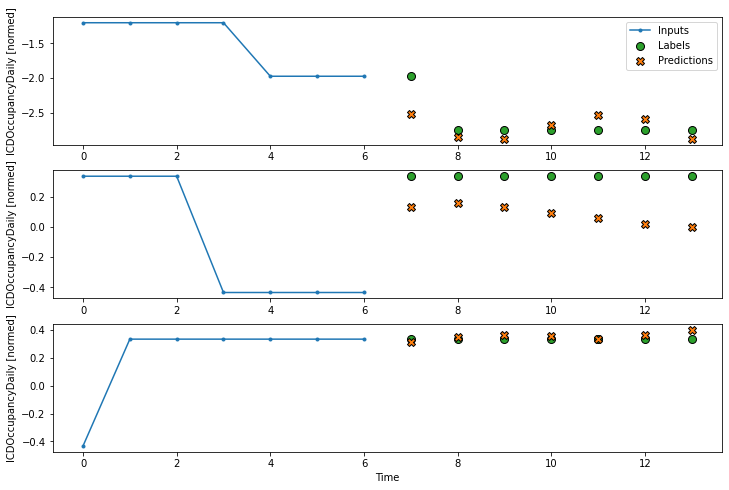

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

Comparison of performance

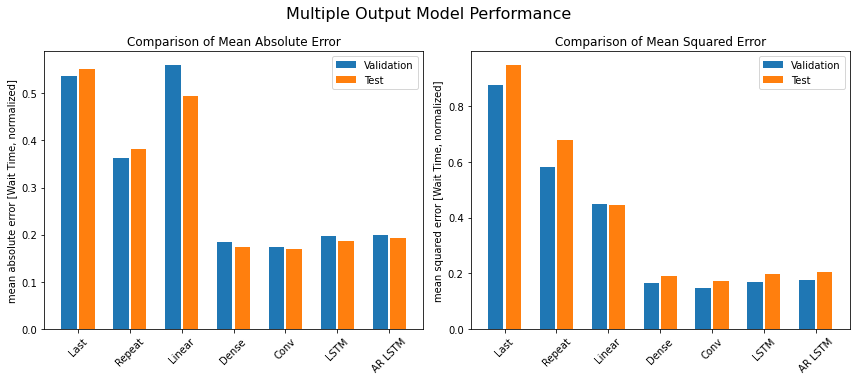

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

metric_name = 'mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in multi_val_performance.values()]
test_mse = [v[metric_index] for v in multi_performance.values()]

metric_name = 'root_mean_squared_error'
metric_index = multi_lstm_model.metrics_names.index('root_mean_squared_error')
val_rmse = [v[metric_index] for v in multi_val_performance.values()]
test_rmse = [v[metric_index] for v in multi_performance.values()]


metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mape = [v[metric_index] for v in multi_val_performance.values()]
test_mape = [v[metric_index] for v in multi_performance.values()]

fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Mean Absolute Error')
plt.ylabel('mean absolute error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Squared Error')
plt.ylabel('mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(), rotation=45)
_ = plt.legend()

fig.suptitle("Multiple Output Model Performance", y=1.05, size=16)
fig.tight_layout()

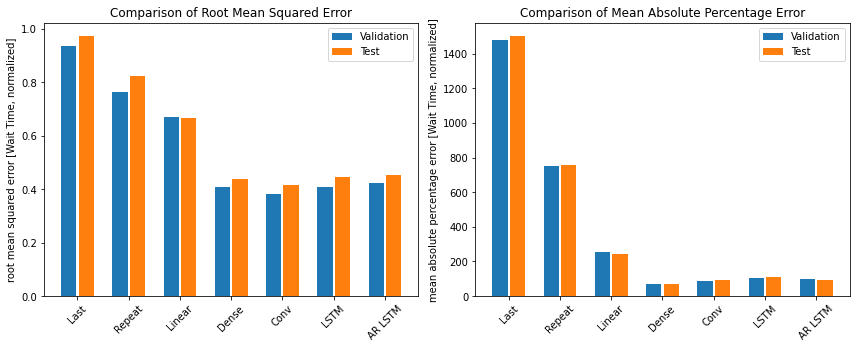

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
plt.title('Comparison of Root Mean Squared Error')
plt.ylabel('root mean squared error [Wait Time, normalized]')
plt.bar(x - 0.17, val_rmse, width, label='Validation')
plt.bar(x + 0.17, test_rmse, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

plt.subplot(1,2,2)
plt.title('Comparison of Mean Absolute Percentage Error')
plt.ylabel('mean absolute percentage error [Wait Time, normalized]')
plt.bar(x - 0.17, val_mape, width, label='Validation')
plt.bar(x + 0.17, test_mape, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()
fig.tight_layout()

In [ ]:
method = ['------ MAE Comparison ------', '------ MSE Comparison ------', '------ RMSE Comparison ------', '------ MAPE Comparison ------']

for i in range(4):
  print(method[i])
  for name, value in multi_performance.items():
    print(f'{name:12s}: {value[i+1]:0.4f}')

------ MAE Comparison ------
Last        : 0.5516
Repeat      : 0.3817
Linear      : 0.4951
Dense       : 0.1737
Conv        : 0.1695
LSTM        : 0.1877
AR LSTM     : 0.1929
------ MSE Comparison ------
Last        : 0.9495
Repeat      : 0.6774
Linear      : 0.4454
Dense       : 0.1912
Conv        : 0.1740
LSTM        : 0.1974
AR LSTM     : 0.2046
------ RMSE Comparison ------
Last        : 0.9744
Repeat      : 0.8230
Linear      : 0.6674
Dense       : 0.4373
Conv        : 0.4172
LSTM        : 0.4443
AR LSTM     : 0.4524
------ MAPE Comparison ------
Last        : 1502.2990
Repeat      : 757.7842
Linear      : 245.9247
Dense       : 72.0740
Conv        : 91.0130
LSTM        : 109.8341
AR LSTM     : 91.7826
